### Now, define a full pipeline for calibration, wavefront detection, and then waveform inference with CNN-labeled data!

Pipeline will have the follow inputs:
1. Wavefront detection CNN training video filename, start_s, duration_s
    1. The surfspot (and registered calibration filenames in pipelines.py) is parsed from this training video filename as characters before the first _.
    1. This video is also used for labeling the training data for the CNN via waveform inference 
1. Waveform inference video filename (could be the same as 2., or any other video file from this surfspot)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# This is the calibration and rough wavefront supervision graph used for training the initial wavefront model 
# This graph is generated inside the WaveformVideoDataset class, and used to cache and output training batches
import numpy as np
from surfbreak.pipelines import video_to_waveform_tensor
from surfbreak.detection import detect_surfzone, trim_image
video_filepath='../data/shirahama_1590387334_SURF-93cm.ts'

In [ ]:
from surfbreak.pipelines import video_to_waveform_array_txy, video_to_trimmed_array_yxt
from surfbreak.graphutils import visualize

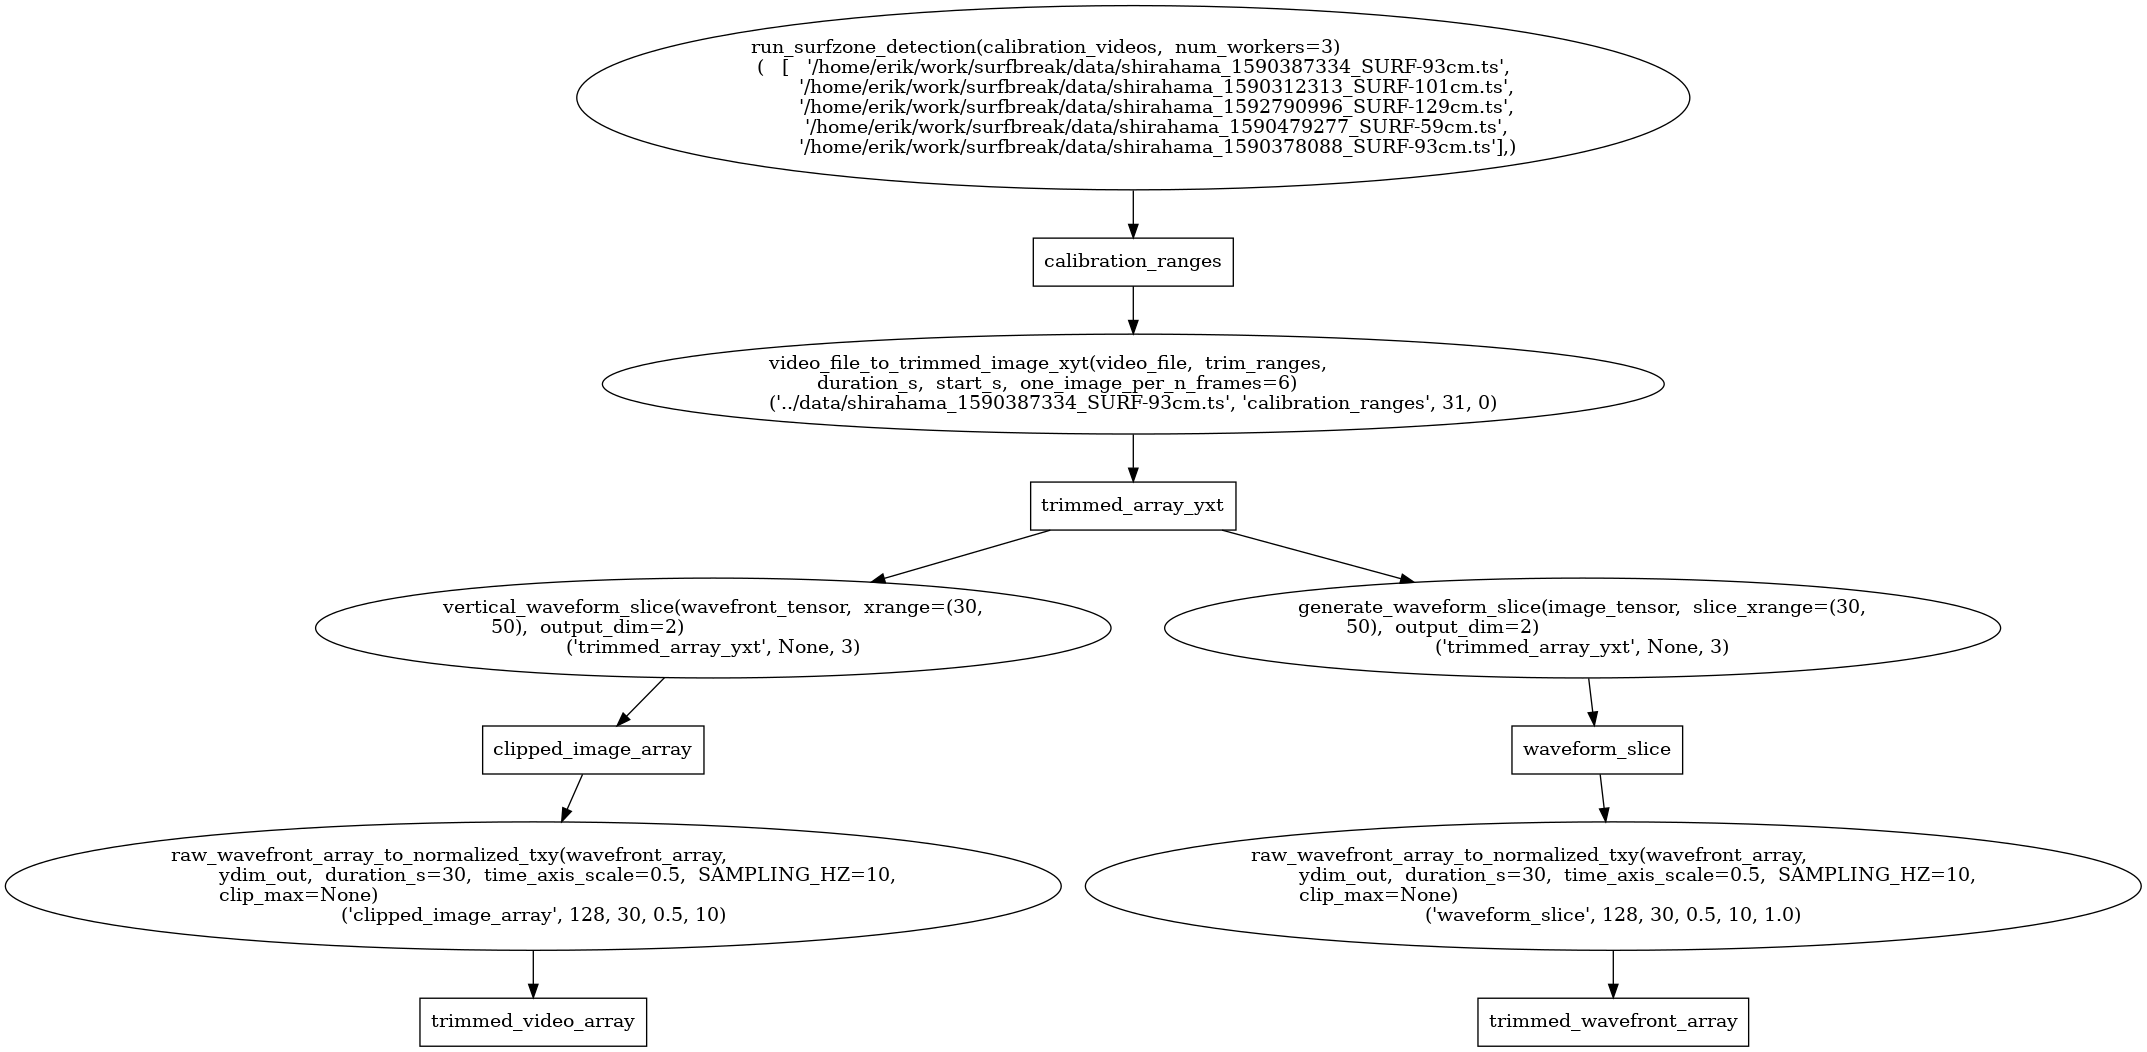

In [ ]:
dask_graph = video_to_waveform_array_txy(video_filepath, ydim_out=128)
visualize(dask_graph, rankdir='UD')

(150, 1036, 128)


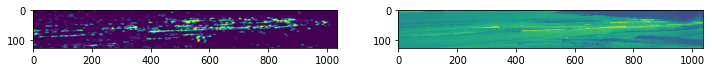

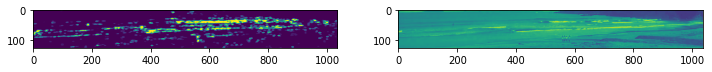

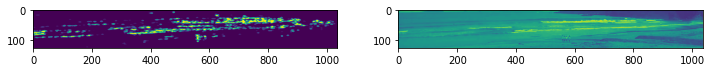

In [ ]:
import graphchain
import matplotlib.pyplot as plt
vid_array = graphchain.get(dask_graph, 'trimmed_video_array')
wavefront_array = graphchain.get(dask_graph, 'trimmed_wavefront_array')
print(vid_array.shape)
for t in range(3):
    fig, ax = plt.subplots(ncols=2, figsize=(12,3))
    ax[0].imshow(wavefront_array[t*5].T)
    ax[1].imshow(vid_array[t*5].T)
    plt.show()

#### Step 1, calibrate on videos and train a waveform model with basic wavefront supervision

Now we use the graph above to train a wavefunction model on the roughly supervised wavefront signal

In [ ]:
%load_ext autoreload
%autoreload 2
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import LitSirenNet
from surfbreak.datasets import WaveformVideoDataset, WaveformChunkDataset, InferredWaveformDataset
from datetime import datetime


wf_labeling_training_video = '../data/shirahama_1590387334_SURF-93cm.ts'

from surfbreak.model_training import train_basic_waveform_model

#### Now use the trained waveform model to label normalized video data, and train a CNN to directly predict the waveform signal

In [ ]:
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import LitSirenNet, LitWaveCNN
from surfbreak.model_training import train_wavefront_detection_cnn

In [ ]:
wf_labeling_training_video

'../data/shirahama_1590387334_SURF-93cm.ts'

In [ ]:
from surfbreak.graphutils import visualize
from surfbreak.pipelines import wavedetection_cnn_training

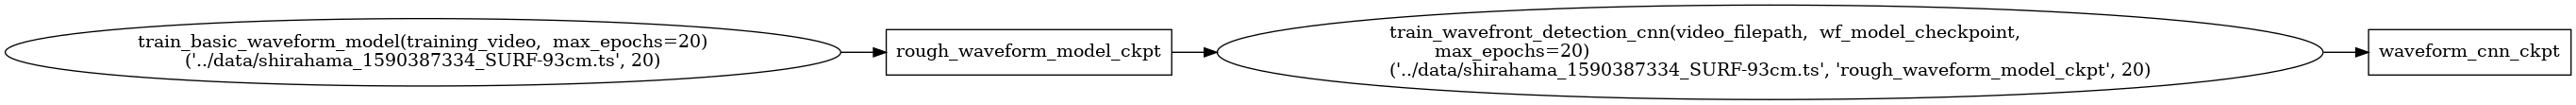

In [ ]:
wf_graph = wavedetection_cnn_training(wf_labeling_training_video)
visualize(wf_graph)

In [ ]:
import graphchain
cnn_checkpoint = graphchain.get(wf_graph, 'waveform_cnn_ckpt')
cnn_checkpoint

'__graphchain_cache__/pipeline_cnn_07-11-2020_19-28-15.ckpt'

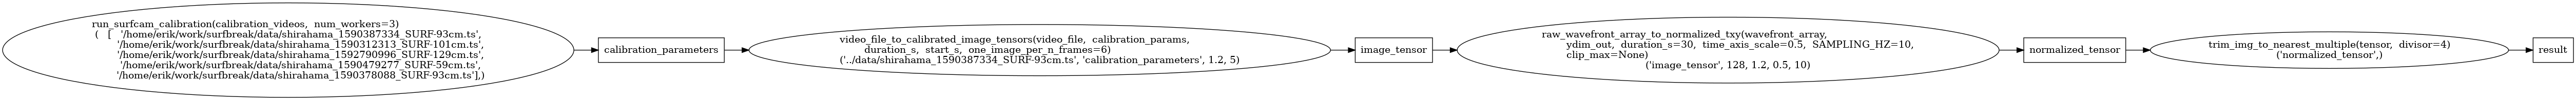

In [ ]:
from surfbreak.pipelines import video_to_trimmed_tensor
wf_graph = video_to_trimmed_tensor(wf_labeling_training_video, start_s=5, duration_s=1.2, time_axis_scale=0.5)
visualize(wf_graph)

(6, 1312, 128)


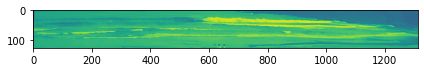

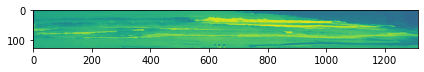

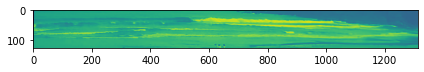

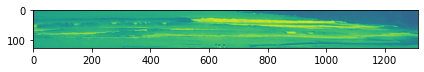

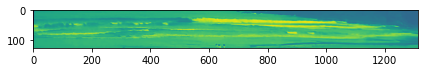

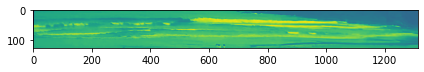

In [ ]:
import matplotlib.pyplot as plt
trimmed_tensor = graphchain.get(wf_graph, 'result')
print(trimmed_tensor.shape)
for t in range(trimmed_tensor.shape[0]):
    plt.imshow(trimmed_tensor[t].T)
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
def detect_wavefronts(wf_cnn_checkpoint, video_tensor):
    wavecnn_model = LitWaveCNN.load_from_checkpoint(wf_cnn_checkpoint)
    # Append the second channel with time-delta intensity
    input_img_array_tcxy = np.concatenate((video_tensor[:-1][None,...], 
                                          video_tensor[1:][None,...] - video_tensor[:-1][None,...]), axis=0).transpose(1,0,2,3)
    return wavecnn_model(torch.from_numpy(input_img_array_tcxy))
    

In [ ]:
inferred_wf_tensor = detect_wavefronts(cnn_checkpoint, trimmed_tensor)
inferred_wf_tensor.shape

torch.Size([5, 1, 1312, 128])

In [ ]:
from torch.utils.data import Dataset
from surfbreak.pipelines import video_to_trimmed_tensor
from surfbreak.datasets import video_txy_to_wavecnn_array_cxy, get_mgrid
from surfbreak.datasets import WavefrontSupervisionDataset

In [ ]:
input_video = '../data/shirahama_1590387334_SURF-93cm.ts'
CNND = WavefrontSupervisionDataset(input_video, cnn_checkpoint, time_chunk_duration_s=10, time_chunk_stride_s=10, timerange=(0,60))
print(CNND.video_chunk_timeranges)
model_in, model_gt = CNND[0]
print(model_in['coords_txyc'].shape, model_gt['video_txy'].shape, model_gt['wavefronts_txy'].shape)
assert torch.float32 == model_in['coords_txyc'].dtype == model_gt['video_txy'].dtype == model_gt['wavefronts_txy'].dtype

[[ 0 10]
 [10 20]
 [20 30]
 [30 40]
 [40 50]
 [50 60]]
torch.Size([50, 1312, 128, 3]) torch.Size([50, 1312, 128]) torch.Size([50, 1312, 128])


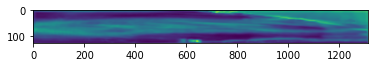

In [ ]:
plt.imshow(CNND.average_wavefront_xy.T)

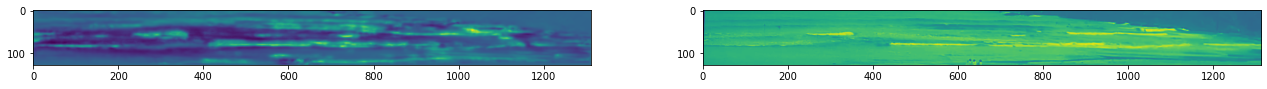

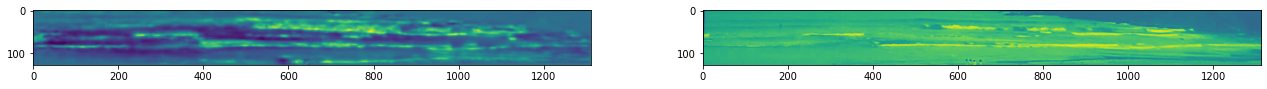

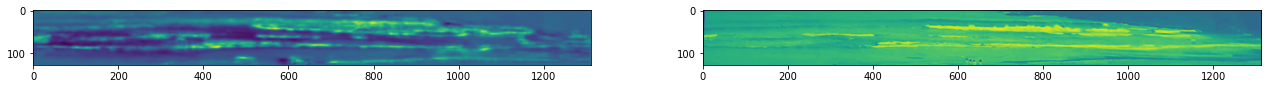

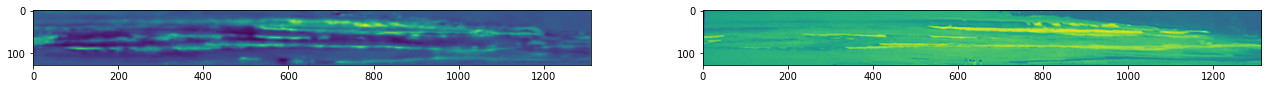

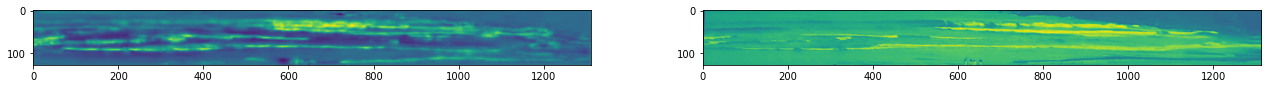

In [ ]:
model_in, model_gt = CNND[0]
for t in range(0,25,5):
    fig, axes = plt.subplots(ncols=2, figsize=(22,2))
    axes[0].imshow(model_gt['wavefronts_txy'][t].T)# - CNND.average_wavefront_xy.T)
    axes[1].imshow(model_gt['video_txy'][t].T)

In [ ]:
tn = model_gt['wavefronts_txy'][0]
tn.shape
tn.reshape(-1,1).shape

torch.Size([167936, 1])

In [ ]:
from surfbreak.datasets import MaskedWavefrontDataset
mds = MaskedWavefrontDataset(CNND, samples_per_batch=30)

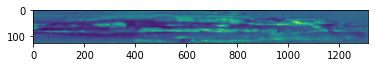

In [ ]:
inputs, gt = mds[0]
plt.imshow(gt['wavefront_values_xy'].T)

In [ ]:
from surfbreak.datasets import WavefrontSupervisionDataset
training_video = '../data/shirahama_1590387334_SURF-93cm.ts'
wf_valid_dataset = WavefrontSupervisionDataset(training_video)

from surfbreak.datasets import CachedDataset
cached_wfvalid = CachedDataset(WavefrontSupervisionDataset, training_video)

for t in range(len(cached_wfvalid)):
    assert cached_wfvalid[t].__repr__() == wf_valid_dataset[t].__repr__()

In [ ]:
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import WaveformNet
from surfbreak.datasets import CachedDataset
from surfbreak.datasets import MaskedWavefrontDataset, WavefrontSupervisionDataset

training_video = '../data/shirahama_1590387334_SURF-93cm.ts'
max_epochs=20
wf_net_kwargs = dict(
    hidden_features=256,
    hidden_layers=3,
    first_omega_0=2.5,
    hidden_omega_0=11,
    squared_slowness=0.20,
    steps_per_vid_chunk=100,
    learning_rate=1e-4,
    grad_loss_scale=0,
    wavefunc_loss_scale=5.5e-9,
    wavespeed_loss_scale=4e-4, 
    xrange=(0,400),
    timerange=(0,1*30),
    chunk_duration=30,
    chunk_stride=30
)

txy_cache = CachedDataset(WavefrontSupervisionDataset, training_video,
                          timerange=(0,60), time_chunk_duration_s=1, time_chunk_stride_s=1)
wf_train_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=0.5)
wf_valid_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=1.0)
viz_txy_dataset = WavefrontSupervisionDataset(training_video, timerange=(0,30), time_chunk_duration_s=30, time_chunk_stride_s=30)

wavefunc_model = WaveformNet(train_dataset=wf_train_dataset, valid_dataset=wf_valid_dataset,
                             viz_dataset=viz_txy_dataset, batch_size=64)

tb_logger = pl.loggers.TensorBoardLogger('logs/', name="wfnet")
trainer = pl.Trainer(logger=tb_logger, limit_val_batches=30,
                     max_epochs=max_epochs, # 20 
                     gpus=1 if torch.cuda.is_available() else None,)

pl.seed_everything(42)
trainer.fit(wavefunc_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


1